In [101]:
import requests
url = 'http://34.172.183.44:8080/'

import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [102]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [103]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [104]:
import requests
from time import time
# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below.
url = 'http://34.72.242.226:8080/'

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      rq = results_quality(true_wids, pred_wids)

  except:
    pass

  qs_res.append((q, duration, rq))

In [105]:
print(qs_res)


[('genetics', 0.4279906749725342, 0.642), ('Who is considered the "Father of the United States"?', 11.372857570648193, 0.044), ('economic', 1.3172526359558105, 0.487), ('When was the United Nations founded?', 11.027361392974854, 0.046), ('video gaming', 3.335150718688965, 0.14), ('3D printing technology', 1.889423131942749, 0.583), ('Who is the author of "1984"?', 3.096790313720703, 0.0), ('bioinformatics', 0.3045220375061035, 0.608), ('Who is known for proposing the heliocentric model of the solar system?', 7.995819807052612, 0.509), ('Describe the process of water erosion.', 4.509154319763184, 0.5), ('When was the Berlin Wall constructed?', 2.703657388687134, 0.551), ('What is the meaning of the term "Habeas Corpus"?', 3.0832836627960205, 0.672), ('telecommunications', 0.37085628509521484, 0.122), ('internet', 0.7272665500640869, 0.595), ('What are the characteristics of a chemical element?', 1.5717017650604248, 0.422), ('Describe the structure of a plant cell.', 4.4938273429870605, 

Analayzing The Results:

In [106]:
import matplotlib.pyplot as plt
import numpy as np
data=qs_res

words = [item[0] for item in data]
times = [item[1] for item in data]
qualities = [item[2] for item in data]

Mean:

In [107]:
qualitiesMean=np.mean(qualities)
timeMean=np.mean(times)
print(np.mean(times))
print(np.mean(qualities))
sorted_data_by_duration_desc = sorted(data, key=lambda x: x[1], reverse=True)
sorted_data_by_quality_desc = sorted(data, key=lambda x: x[2], reverse=True)


2.9478023370107014
0.4083666666666667


Scatter Plot For Time And Results Quality:

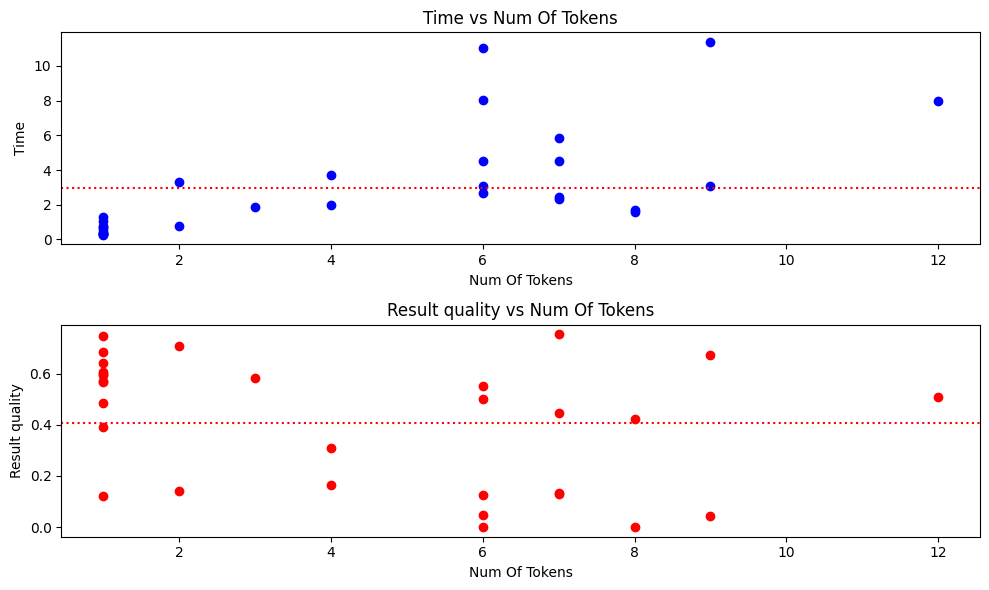

In [108]:
num_words = [len(word.split()) for word in words]
# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(num_words, times, color='b')
plt.axhline(y=np.mean(times), color='red', linestyle='dotted')
plt.title('Time vs Num Of Tokens')
plt.xlabel('Num Of Tokens')
plt.ylabel('Time')

plt.subplot(2, 1, 2)
plt.scatter(num_words, qualities, color='r')
plt.axhline(y=np.mean(qualities), color='red', linestyle='dotted')
plt.title('Result quality vs Num Of Tokens')
plt.xlabel('Num Of Tokens')
plt.ylabel('Result quality')

plt.tight_layout()
plt.show()


The Connection between Questions RQ and Time:
Number Of Questions Vs. Non Questions

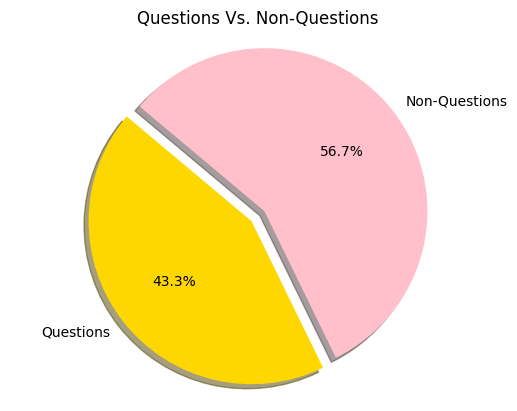

In [109]:
questions=[]
nonquestions=[]
for item in data:
  if "?" in item[0]:
    questions.append(item)
  else:
    nonquestions.append(item)
# Calculate word lengths
labels = ['Questions', 'Non-Questions']
sizes = [len(questions)/(len(questions)+len(nonquestions)), len(nonquestions)/(len(questions)+len(nonquestions))]  # Values for each slice
colors = ['gold', 'pink']  # Colors for each slice
explode = (0, 0.1)  #
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Questions Vs. Non-Questions')
plt.show()




Mean Time Q vs. Non-Q





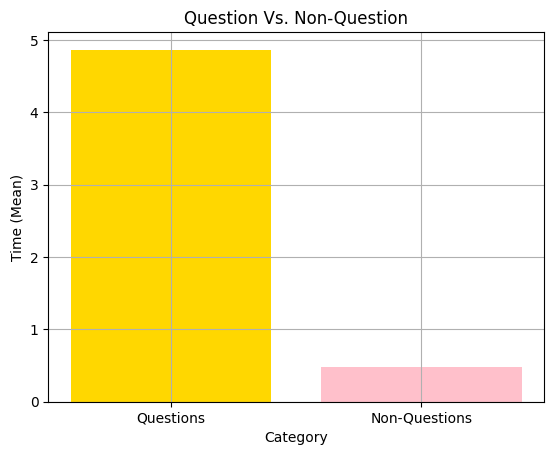

In [110]:
question_times = [item[1] for item in questions]
non_question_times= [item[2] for item in nonquestions]
categories = ['Questions', 'Non-Questions']
values = [np.mean(question_times), np.mean(non_question_times)]

# Create bar plot
plt.bar(categories, values,color=colors)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Time (Mean)')
plt.title('Question Vs. Non-Question')

plt.grid(True)
plt.show()


Mean Num Of Tokens Q vs. Non-Q


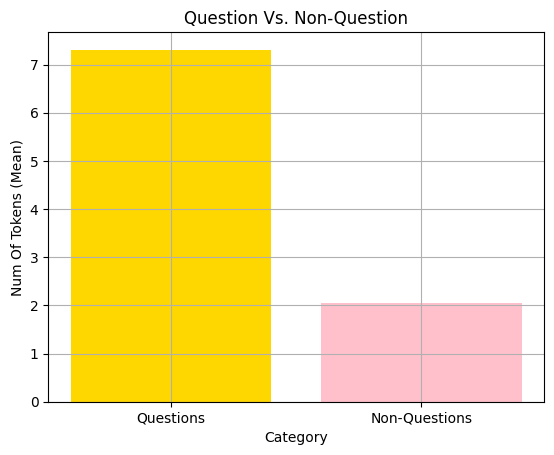

In [111]:

question_lengths=[len(item[0].split(" ")) for item in questions]
nonquestions_lengths=[len(item[0].split(" ")) for item in nonquestions]
categories = ['Questions', 'Non-Questions']
values = [np.mean(question_lengths), np.mean(nonquestions_lengths)]
plt.bar(categories, values,color=colors)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Num Of Tokens (Mean)')
plt.title('Question Vs. Non-Question')

plt.grid(True)
plt.show()


Are all Questions Slow?

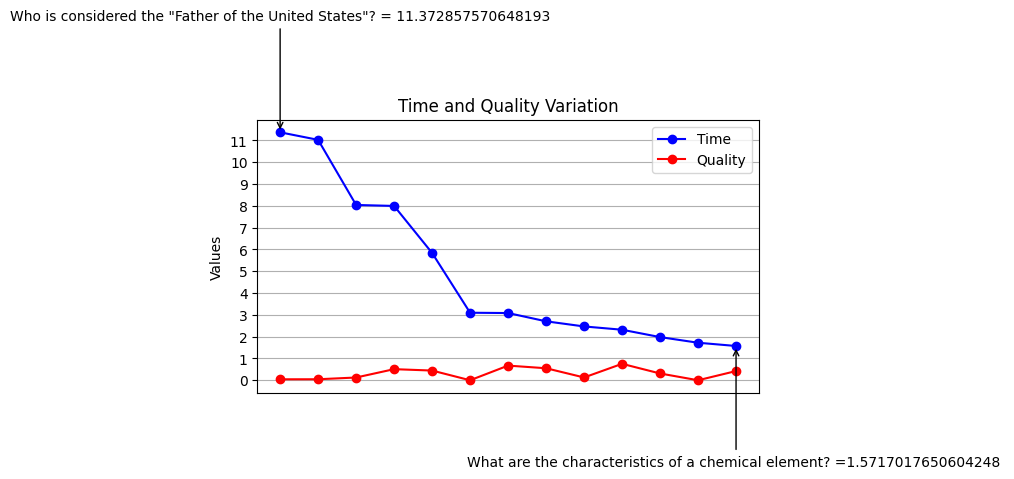

In [112]:
sortedQTimes=sorted(questions,key=lambda x: x[1],reverse=True)
titles = [item[0] for item in sortedQTimes]
times = [item[1] for item in sortedQTimes]
qualities = [item[2] for item in sortedQTimes]

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

# Plot time
ax.plot(titles, times, marker='o', color='blue', label='Time')

# Plot quality
ax.plot(titles, qualities, marker='o', color='red', label='Quality')

# Add labels and title
ax.set_ylabel('Values')
ax.set_title('Time and Quality Variation')

# Add legend
ax.legend()

# Find the index of the highest and lowest time
highest_time_index = times.index(max(times))
lowest_time_index = times.index(min(times))

# Annotate the highest time and lowest time
ax.annotate(f"{sortedQTimes[0][0]} = {sortedQTimes[0][1]}", xy=(titles[highest_time_index], times[highest_time_index]), xytext=(titles[highest_time_index], times[highest_time_index] + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center', verticalalignment='bottom')

ax.annotate(f"{sortedQTimes[len(sortedQTimes)-1][0]} ={sortedQTimes[len(sortedQTimes)-1][1]} ", xy=(titles[lowest_time_index], times[lowest_time_index]), xytext=(titles[lowest_time_index], times[lowest_time_index] - 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center', verticalalignment='top')

# Remove x-axis ticks
ax.set_xticks([])
ax.set_yticks(range(int(min(qualities)), int(max(times))+1, 1))

plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
from Tokenizer import Tokenizer
tokenizer=Tokenizer()
query_stemmed1 = list(set(tokenizer.tokenize(sortedQTimes[0][0])))
query_stemmed2 = list(set(tokenizer.tokenize(sortedQTimes[len(sortedQTimes)-1][0])))

print(query_stemmed1,query_stemmed2)


['father', 'unit', 'state', 'consid'] ['chemic', 'element', 'characterist']


Not Much difference at amount of words, maybe at postings list retrival time?
